In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
scripts_path = Path("../Modeling/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
from scripts.data_visualiser import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.get_statistics import *
from Pipeline.pre_processing_pipeline import *
import numpy as np
import preprocessing_config as config

In [4]:
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

## Week 3

In [5]:
images = load_sentinel_images_temporal('/Users/bhumikasadbhave007/Documents/THWS/Semester-4/MASTER-THESIS/Temporal-Data/test/first-10')

(1000, 1000, 13)
(1000, 1000, 13)
(1000, 1000, 13)
(1000, 1000, 13)
(1000, 1000, 13)
(1000, 1000, 13)


: 

In [7]:
len(images)

4

In [8]:
masked_images = mask_images_temporal(images)

In [10]:
fields = extract_fields_temporal(images, config.field_size)

--- Processed 4 regions for scene 0
--- Processed 1 regions for scene 1
--- Processed 4 regions for scene 2
--- Processed 9 regions for scene 3


In [11]:
len(fields)

18

In [12]:
fields[0][0].shape

(64, 64, 13)

In [13]:
refined_fields = refine_temporal_stack_interval5(fields, config.temporal_stack_size, config.temporal_points)

In [14]:
len(refined_fields)

18

In [23]:
refined_fields[0][0].shape

(64, 64, 13)

##### Image Diseased

In [19]:
np.unique(refined_fields[6][1][:,:,-2])

array([      0., 1177174.])

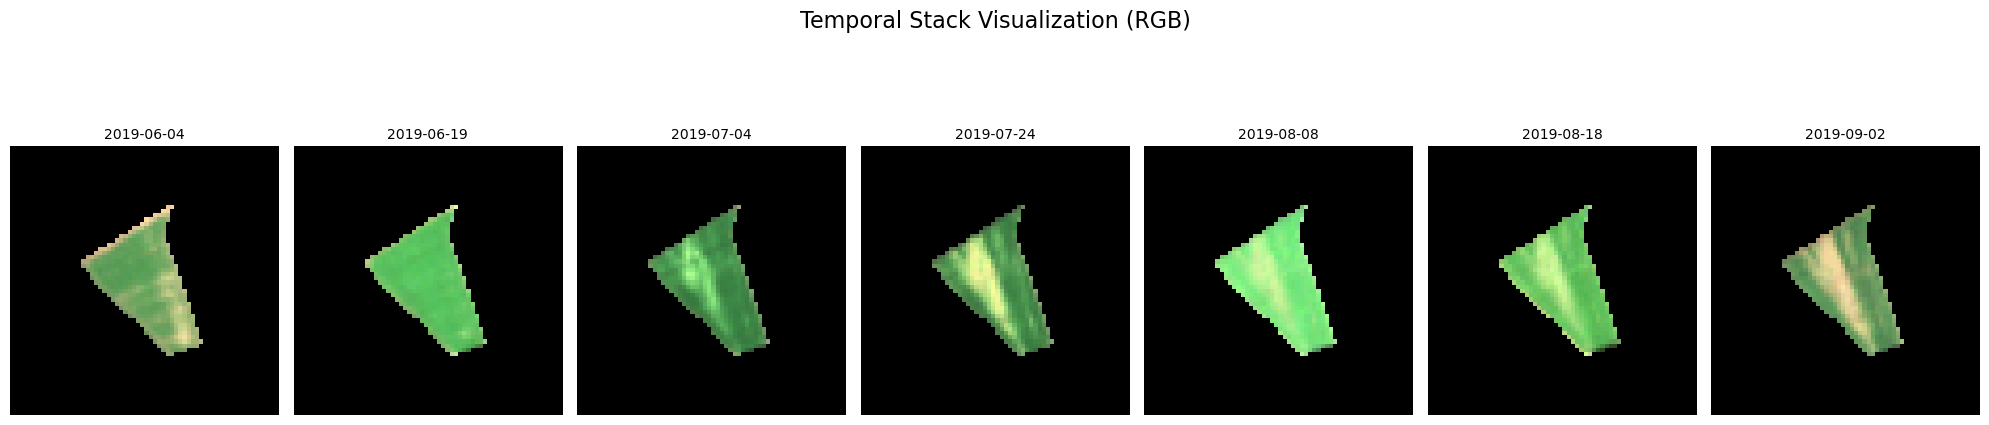

In [26]:
visualize_temporal_stack_rgb(refined_fields[8])

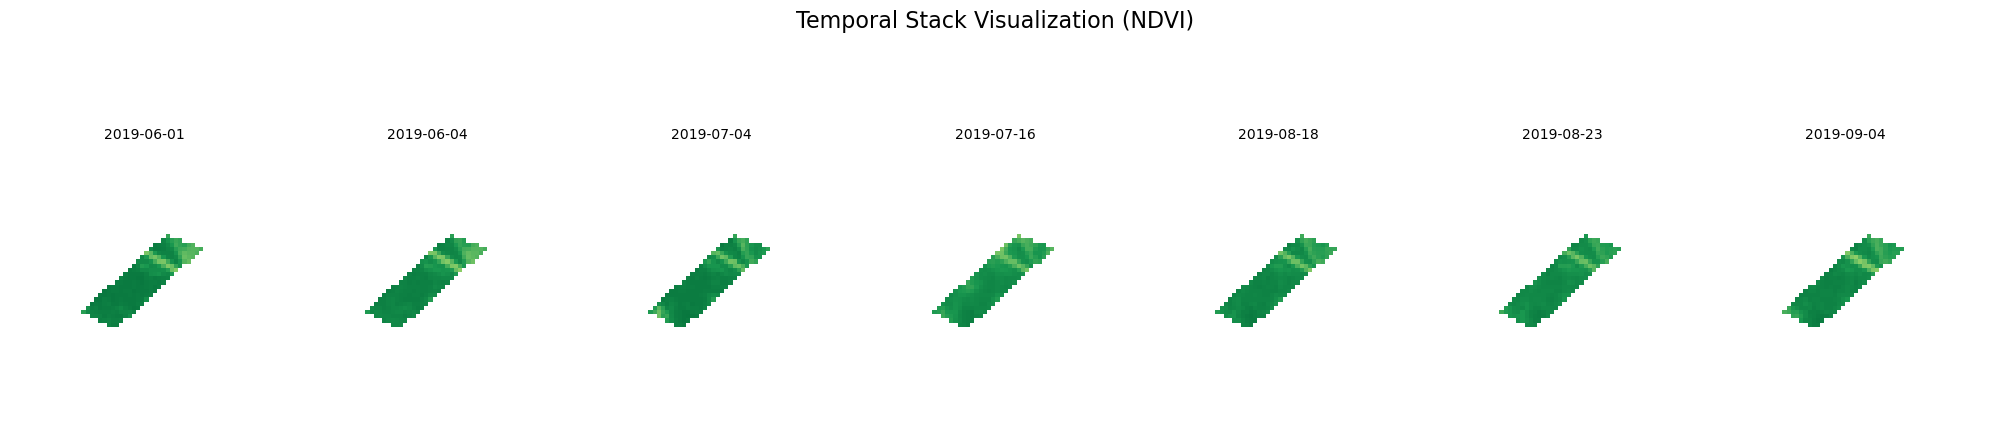

In [72]:
visualize_temporal_stack_ndvi(refined_fields[1])

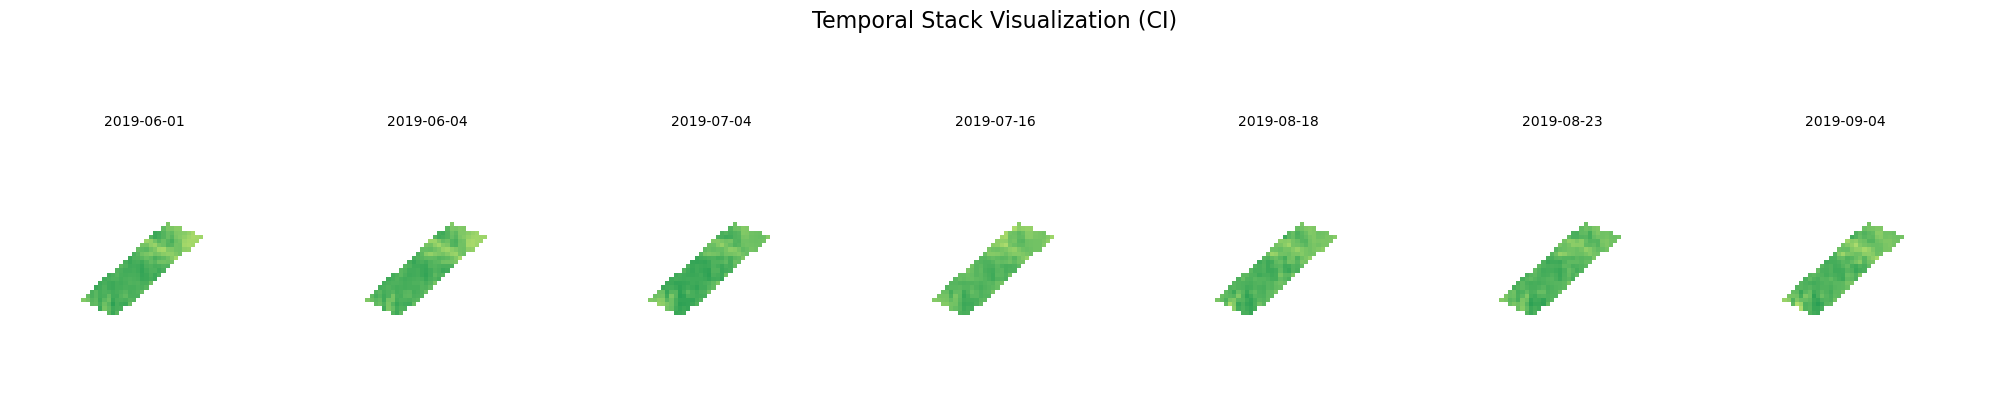

In [73]:
visualize_temporal_stack_ci(refined_fields[1])

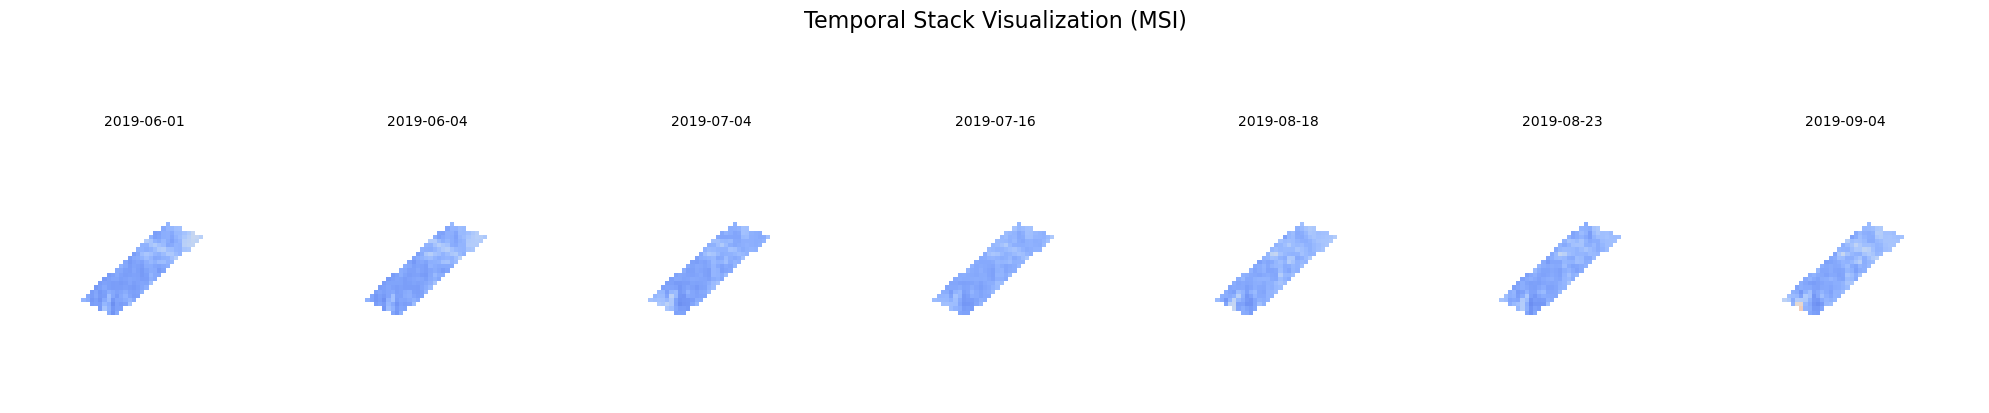

In [74]:
visualize_temporal_stack_msi(refined_fields[1])

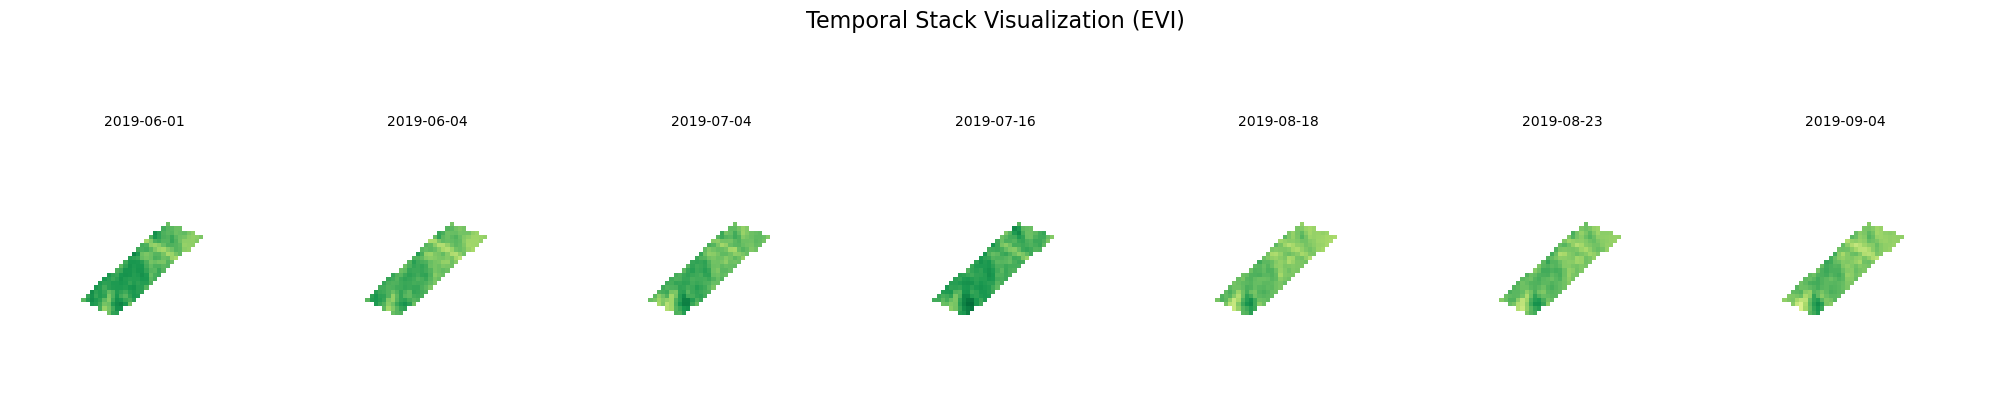

In [75]:
visualize_temporal_stack_evi(refined_fields[1])

## Week 4/5

##### Visualisation Bounding Box

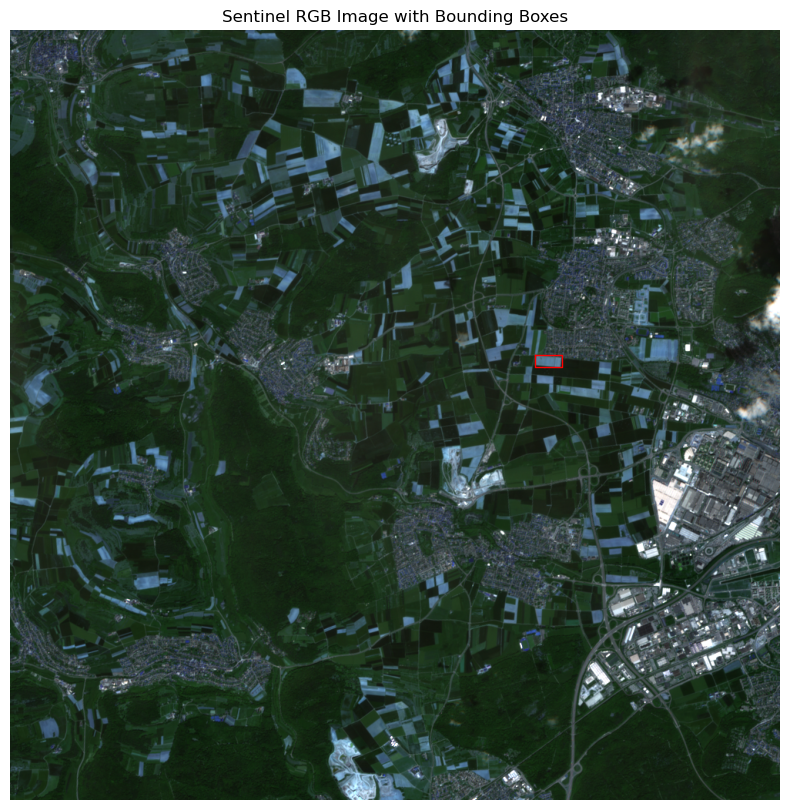

In [ ]:
rgb_image = images[2][7][:,:,:3] #[:, :, [2, 1, 0]]  # Red, Green, Blue bands
# rgb_image = sm_rotated[:,:,:3]

# Normalize RGB image for visualization
rgb_normalized = (rgb_image - np.min(rgb_image)) / (np.max(rgb_image) - np.min(rgb_image))
brightness_factor = 5  # >1 to increase brightness, <1 to decrease
rgb_adjusted = np.clip(rgb_normalized * brightness_factor, 0, 1)

# Label connected regions in the mask
labeled_mask = label(images[2][7][:,:,-1])
regions = regionprops(labeled_mask)

# Plot the RGB image
plt.figure(figsize=(10, 10))
plt.imshow(rgb_adjusted)
plt.title("Sentinel RGB Image with Bounding Boxes")

# Draw bounding boxes for each region
for region in regions:
    min_row, min_col, max_row, max_col = region.bbox
    # Draw a rectangle around the region
    plt.plot([min_col, max_col, max_col, min_col, min_col],  # x-coordinates
            [min_row, min_row, max_row, max_row, min_row],  # y-coordinates
            color='red', linewidth=1)

plt.axis("off")
plt.show()

#### Other Stuff

In [11]:
success = save_field_images_temporal(config.base_directory_temporal, refined_fields)
success

True

In [7]:
temporal_images = load_field_images_temporal(config.base_directory_temporal_test)

In [8]:
len(temporal_images)

48

In [51]:
np.unique(temporal_images[14][0][:,:,-2])

array([      0., 1178198., 1225298.])

In [53]:
ndvi_images = temporal_differences_with_time(temporal_images,'ndvi')
len(ndvi_images)

48

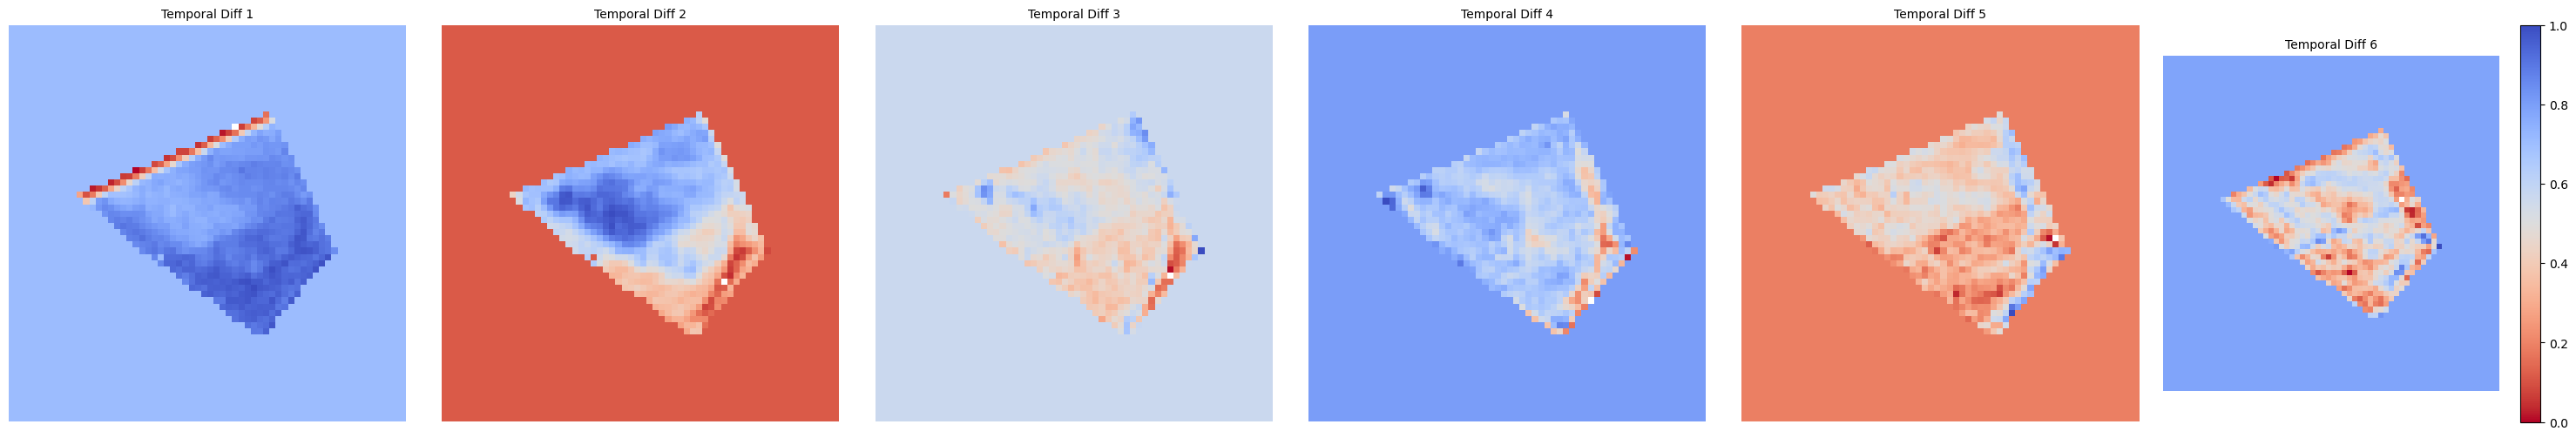

In [54]:
visualize_temporal_differences(ndvi_images[14])

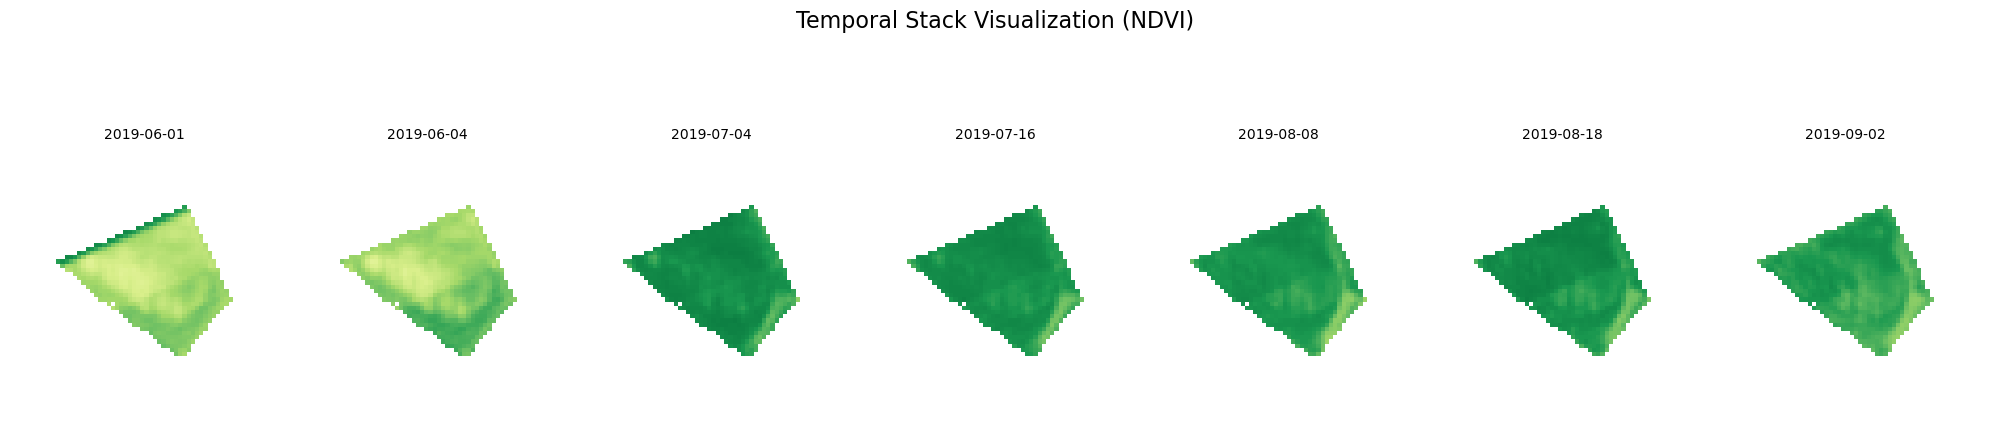

In [55]:
visualize_temporal_stack_ndvi(temporal_images[14])

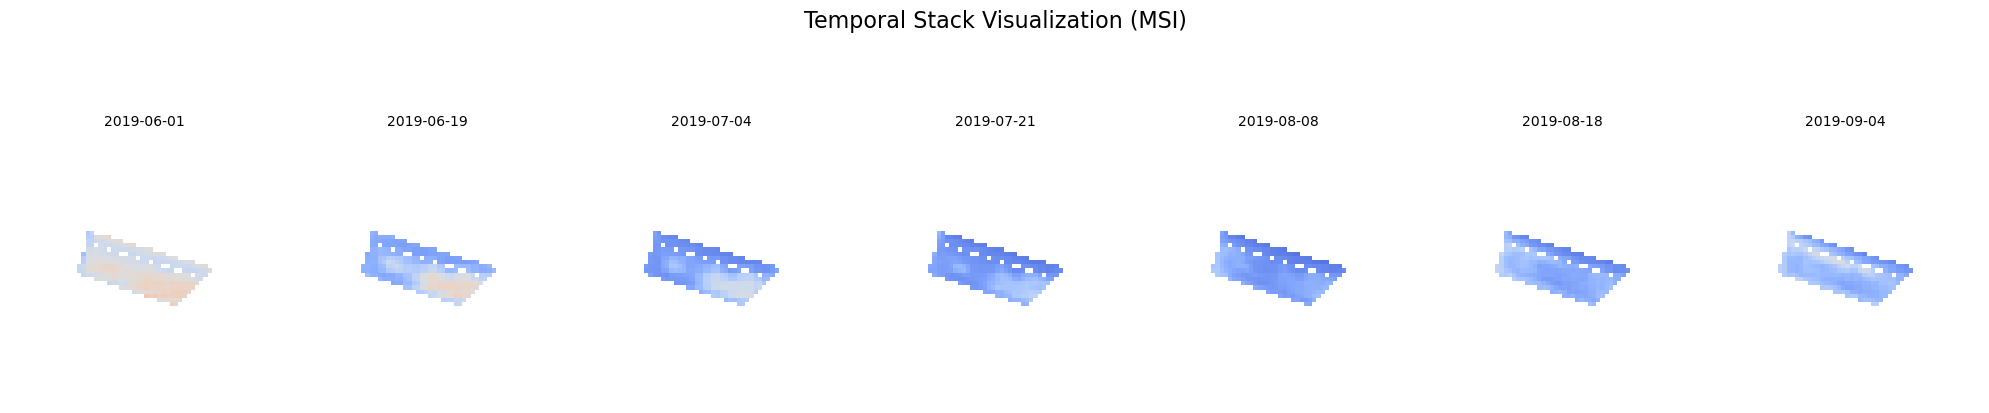

In [28]:
visualize_temporal_stack_msi(temporal_images[4])

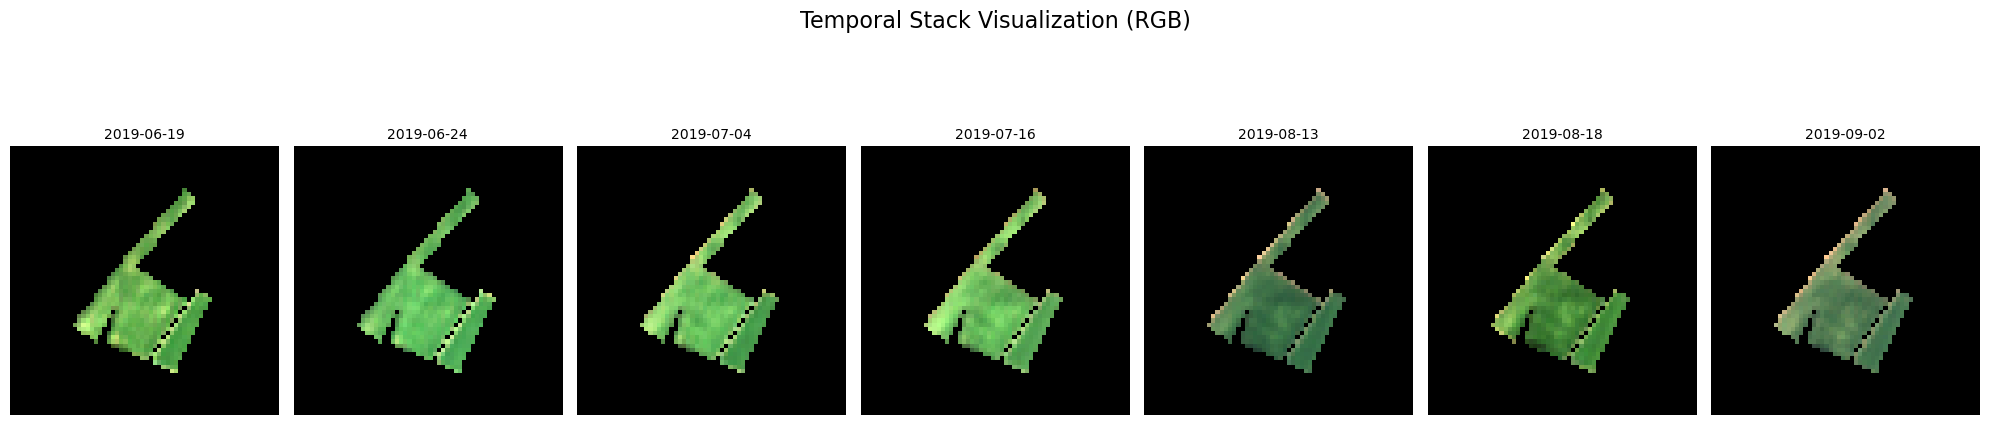

In [41]:
visualize_temporal_stack_rgb(temporal_images[12])

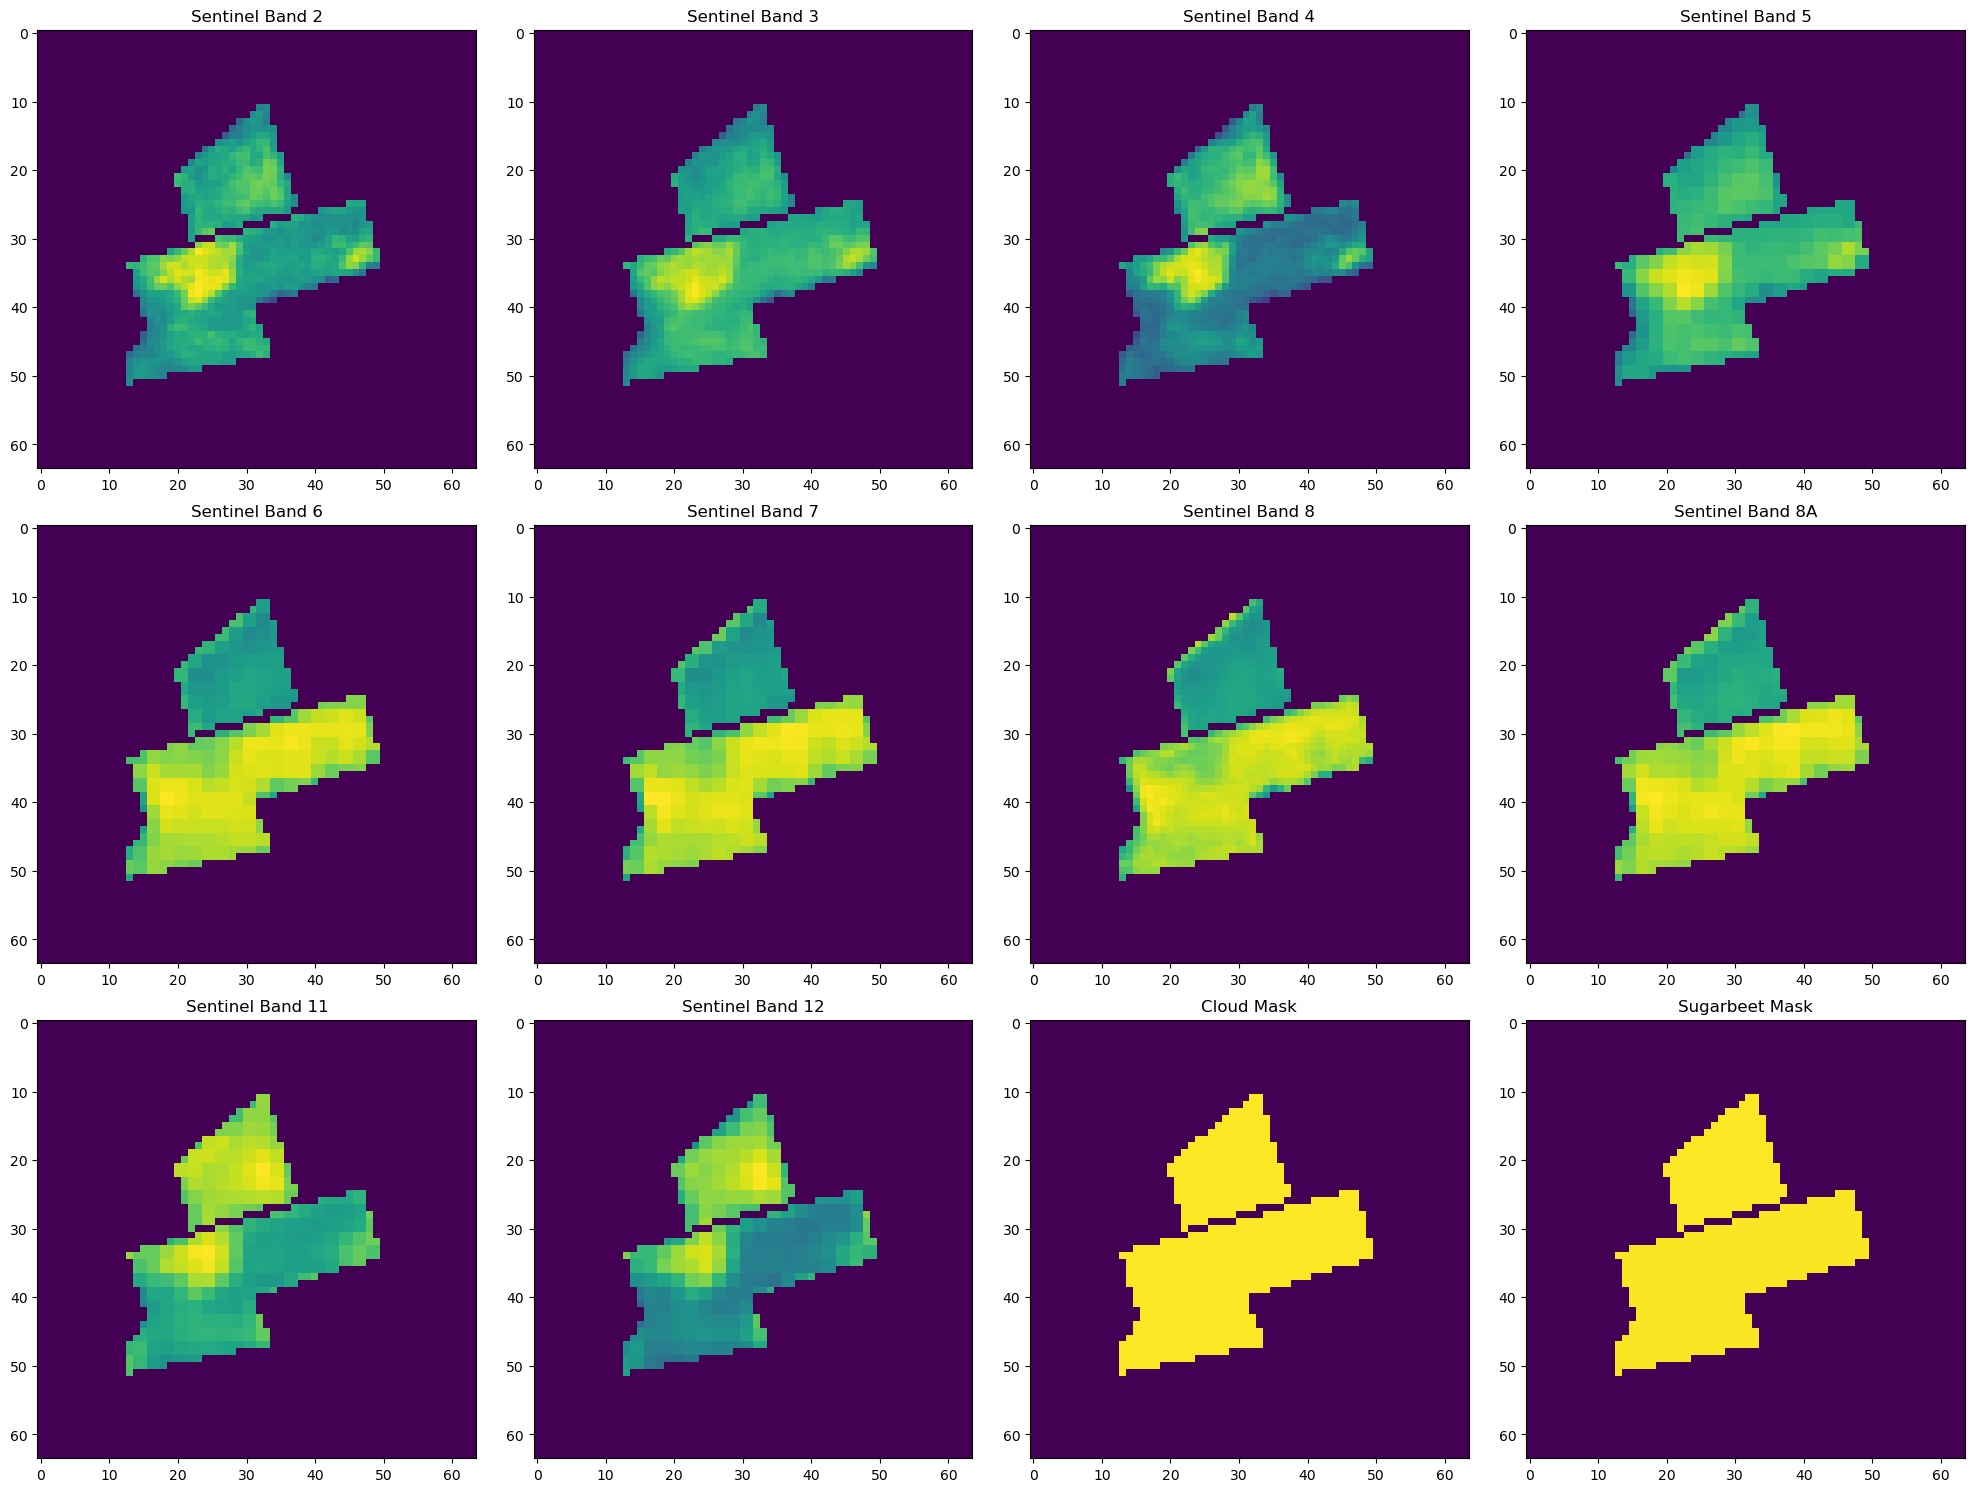

In [115]:
visualise_all_bands(temporal_images[4][-1])

No Disease: 5 

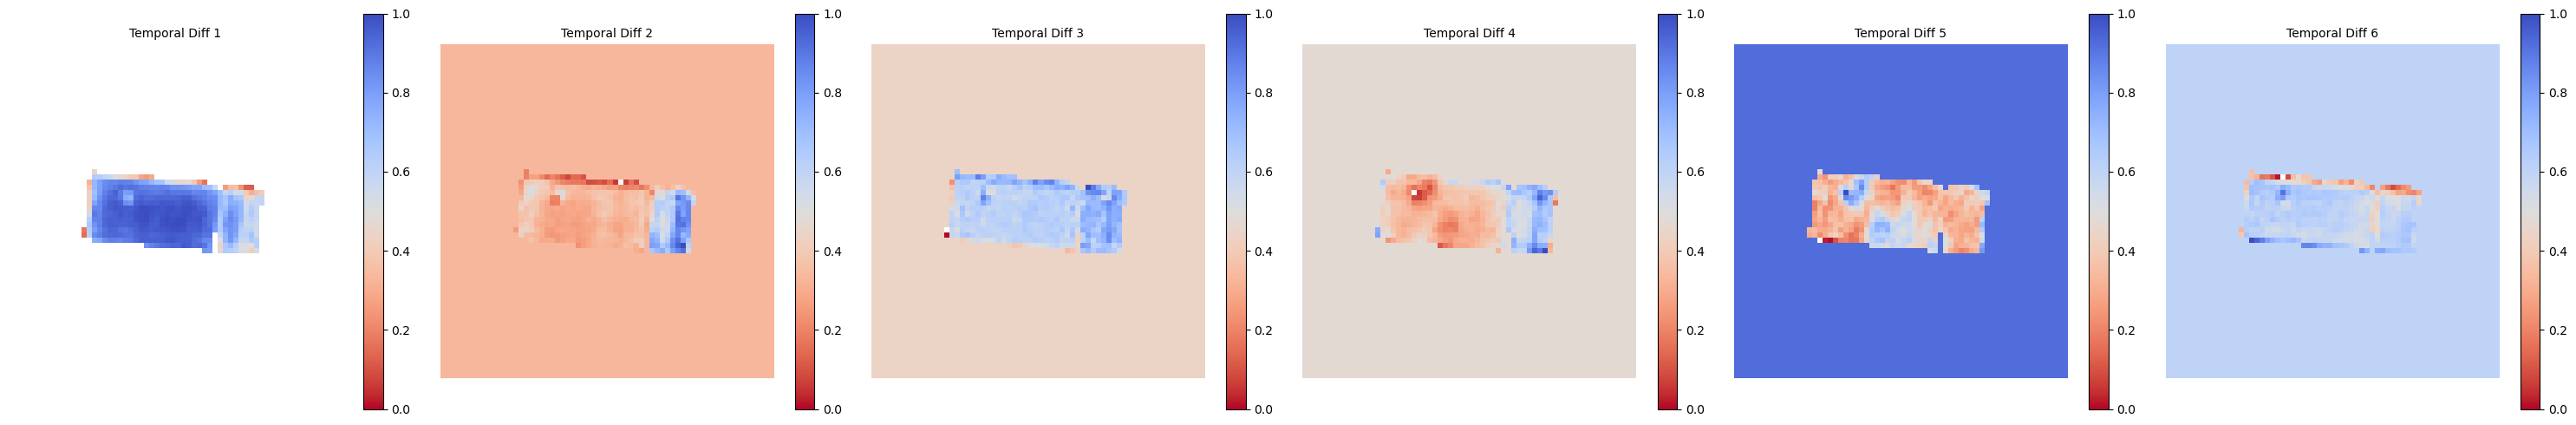

In [ ]:
visualize_temporal_differences(ndvi_images[5])

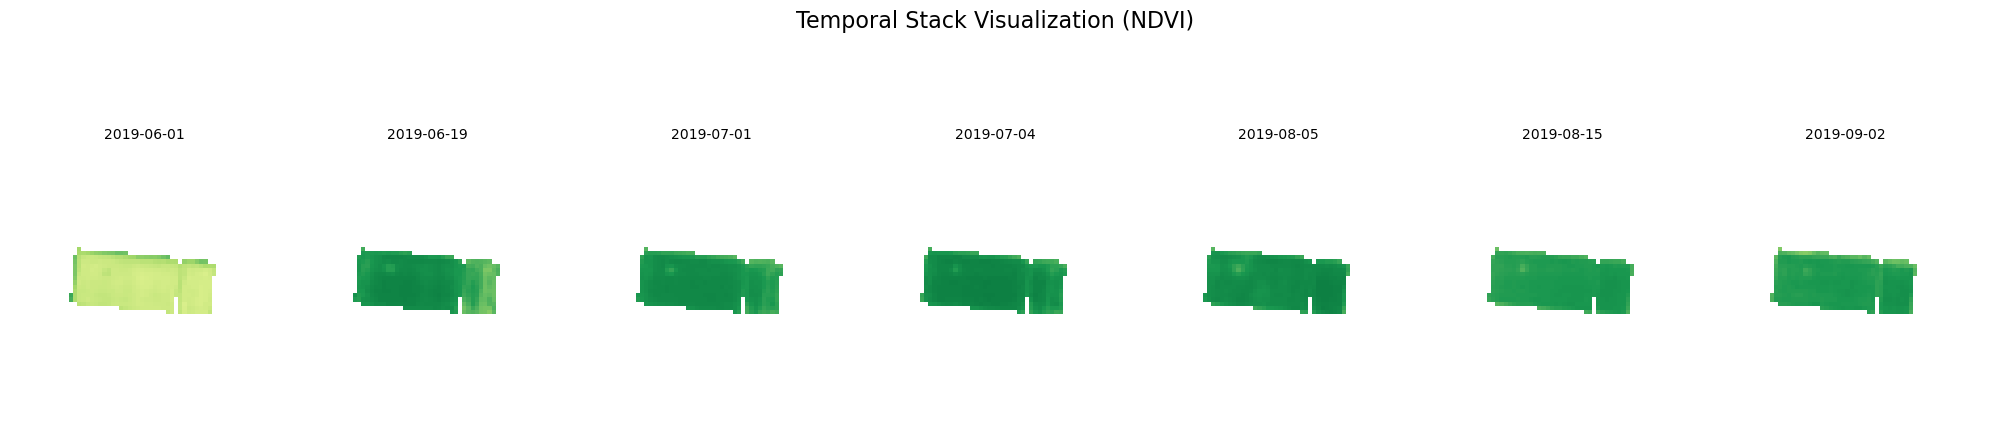

In [ ]:
visualize_temporal_stack_ndvi(temporal_images[5])

In [ ]:
np.unique(temporal_images[7][0][:,:,-2])

array([      0., 1217498.])

## Non-temporal images for BASELINE

In [18]:
simple_images = get_non_temporal_images(temporal_images)

In [19]:
len(simple_images)

48

In [20]:
simple_images[0].shape

(64, 64, 13)

In [21]:
refined_images, field_numbers = refine_chanel_non_temporal(simple_images)

In [22]:
refined_images[0].shape

(64, 64, 3)

In [28]:
resized_images = []
for img in refined_images:
    resized_images.append(resize_with_padding(img))

In [31]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(image, model):

    reshaped_img = image.reshape(1,224,224,3) 
    imgx = preprocess_input(reshaped_img)
    features = model.predict(imgx, use_multiprocessing=True)

    return features

2024-12-20 21:53:42.269467: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-12-20 21:53:42.269491: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-12-20 21:53:42.269497: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-12-20 21:53:42.269861: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-20 21:53:42.270073: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [32]:
data = {}
i=0
for image in resized_images:
    feat = extract_features(image,model)
    name = field_numbers[i]
    data[name] = feat
    i+=1

1/1 [==============================] - 0s 15ms/step


2024-12-20 21:53:48.959091: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 13ms/step


In [37]:
filenames = np.array(list(data.keys()))
feat = np.array(list(data.values()))
feat = feat.reshape(-1,4096)

# # reduce the amount of dimensions in the feature vector
# pca = PCA(n_components=2, random_state=22)
# pca.fit(feat)
# x = pca.transform(feat)

kmeans = KMeans(n_clusters=2, random_state=22)
kmeans.fit(feat)


/Users/bhumikasadbhave007/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [ ]:
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [38]:
acc = get_accuracy(filenames, kmeans.labels_, config.labels_path)
acc

0.5409836065573771

In [41]:
groups[1]

['1172001.0_1225692.0',
 '1177274.0',
 '1177490.0_1183928.0',
 '1178198.0_1225298.0',
 '1179855.0_1187336.0',
 '1182822.0_1216964.0',
 '1194806.0_1194808.0',
 '1196347.0',
 '1216801.0_1216804.0',
 '1222641.0',
 '1223341.0',
 '1224018.0',
 '1226904.0_1227074.0']